# LBFGS

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt

# Iterations v/s Loss Storage
iters = [0]
loss_store = []

# Boundary Conditions 
left_temp = 1
right_temp = 0
x_l = 0
x_r = 0.4
t_i = 0
t_f = 0.1
s_i = 0
T_i = 0

# Parameters of the equation
c1 = 1.0
c2 = 0.5

# Setup training and test dataset
N_div_train = 70
N_bc = 800
N_ic = 800

x_train1 =[]
t_train1 =[]
for i in range(N_div_train):
    for j in range(N_div_train):
        x_train1.append(x_l + (i-1)*(x_r-x_l)/N_div_train)
        t_train1.append(t_i + (j-1)*t_f/N_div_train)

x_train1 = torch.FloatTensor(x_train1)
t_train1 = torch.FloatTensor(t_train1)   
x_bc = torch.ones(N_bc)*x_l
x_ic = torch.rand(N_ic)
t_bc = torch.rand(N_bc)
t_ic = torch.ones(N_ic)*t_i
x_train2 = torch.cat((x_train1,x_bc,x_ic),0)
t_train2 = torch.cat((t_train1,t_bc,t_ic),0)
null = torch.zeros(N_div_train*N_div_train + N_bc + N_ic)

x_train2 = x_train2.unsqueeze(-1)
t_train2 = t_train2.unsqueeze(-1)
x_train = x_train2.clone().detach().requires_grad_(True)
t_train = t_train2.clone().detach().requires_grad_(True)
null = null.unsqueeze(-1)

# Setup NN
n_input = 2
n_output = 1
n_nodes = 30
NN1 = nn.Sequential( nn.Linear(n_input, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_output) )

n_input = 1
NN2 = nn.Sequential( nn.Linear(1, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_output) )

for layer in NN1.modules():
    if isinstance(layer, nn.Linear):
         layer.weight.data.normal_(mean=0, std=0.3)
            
for layer in NN2.modules():
    if isinstance(layer, nn.Linear):
         layer.weight.data.normal_(mean=0, std=0.3)

# Hyper-parameters
learning_rate = 2e-4
n_iters = 32000
            
# Setup Loss function and LBFGS Optimiser
mse = nn.MSELoss()
optimiser = torch.optim.LBFGS([*NN1.parameters(), *NN2.parameters()],
                              lr = learning_rate, 
                              tolerance_change=1e-40,
                              max_iter = n_iters)

# For training NN
def closure(): 
    
    T = NN1( torch.cat((x_train, t_train),1) )
    dTdt = torch.autograd.grad(T, t_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dTdx = torch.autograd.grad(T, x_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dT2dx2 = torch.autograd.grad(dTdx, x_train, grad_outputs=torch.ones_like(dTdx), create_graph=True)[0]
    s = NN2(t_train)
    Ts = NN1( torch.cat((s, t_train),1) )
    dTsdx = torch.autograd.grad(Ts, s, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dsdt = torch.autograd.grad(s, t_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    
    optimiser.zero_grad()
    eq1 = mse( dTdt-c1*dT2dx2, null )
    ic1 = 6*mse( torch.mul(torch.where(t_train == t_i,1,0),(T - T_i)), null )
    bc1 = 6*mse( torch.mul(torch.where(x_train == x_l,1,0),(T - left_temp)), null )
    bc2 = 6*mse( Ts - right_temp, null )
    eq2 = mse( dsdt+c2*dTsdx, null ) 
    ic2 = 6*mse( torch.mul(torch.where(t_train == t_i,1,0),(s - s_i)), null )
    loss = eq1 + bc1 + bc2 + ic1 + eq2 + ic2
    loss.backward()   
    
    iters.append(iters[-1]+1)
    loss_store.append(loss.detach().numpy())
    if iters[-1]%100 == 0:
        print('epoch = ',iters[-1],', loss = ',loss.detach().numpy())
        
    if i%1000 == 0:
        print('eq1_loss = ',eq1.detach().numpy())
        print('ic1_loss = ',ic1.detach().numpy())
        print('bc1_loss = ',bc1.detach().numpy())
        print('bc2_loss = ',bc2.detach().numpy())
        print('eq2_loss = ',eq2.detach().numpy())
        print('ic2_loss = ',ic2.detach().numpy())
        
    return loss

optimiser.step(closure)

# Extract Weights and Biases
w1 = list(NN1.parameters())
w2 = list(NN2.parameters())

KeyboardInterrupt: 

# Adams Optimiser, c1 = c2 = 1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt

# Iterations v/s Loss Storage
iters = [0]
loss_store = []

# Boundary Conditions 
left_temp = 1
right_temp = 0
x_l = 0
x_r = 1
t_i = 0
t_f = 1
s_i = 0.000000001
T_i = 0

# Parameters of the equation
c1 = 1.0
c2 = 0.5

# Setup training and test dataset
N_div_train = 35
N_bc = 200
N_ic = 200
ax = 0.01
rx = (x_r/ax)**(1/(N_div_train-1))
at = 0.01
rt = (t_f/at)**(1/(N_div_train-1))

x_train1 =[]
t_train1 =[]
for i in range(N_div_train):
    for j in range(N_div_train):
#         x_train1.append(x_l + (i-1)*(x_r-x_l)/N_div_train)
        x_train1.append(ax*rx**i)
        t_train1.append(t_i + (j-1)*t_f/N_div_train)
#         t_train1.append(at*rt**i)

x_train1 = torch.FloatTensor(x_train1)
t_train1 = torch.FloatTensor(t_train1)   
x_bc = torch.ones(N_bc)*x_l
x_ic = torch.rand(N_ic)
t_bc = torch.rand(N_bc)
t_ic = torch.ones(N_ic)*t_i
x_train2 = torch.cat((x_train1,x_bc,x_ic),0)
t_train2 = torch.cat((t_train1,t_bc,t_ic),0)
null = torch.zeros(N_div_train*N_div_train + N_bc + N_ic)

x_train2 = x_train2.unsqueeze(-1)
t_train2 = t_train2.unsqueeze(-1)
x_train = x_train2.clone().detach().requires_grad_(True)
t_train = t_train2.clone().detach().requires_grad_(True)
null = null.unsqueeze(-1)

# Setup NN
n_input = 2
n_output = 1
n_nodes = 20
NN1 = nn.Sequential( nn.Linear(n_input, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_output) )

n_input = 1
NN2 = nn.Sequential( nn.Linear(1, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_output) )

for layer in NN1.modules():
    if isinstance(layer, nn.Linear):
         layer.weight.data.normal_(mean=0, std=0.2)
            
for layer in NN2.modules():
    if isinstance(layer, nn.Linear):
         layer.weight.data.normal_(mean=0, std=0.2)

# Hyper-parameters
learning_rate = 2e-4
learning_rate_1 = 9e-5
n_iters = 62000
            
#loss function weights

w1 = 1
w2 = 1
w3 = 6
w4 = 1
w5 = 1
w6 = 12

# Setup Loss function and Optimiser
mse = nn.MSELoss()
# optimiser = torch.optim.SGD([*NN1.parameters(), *NN2.parameters()], lr=learning_rate)
optimiser = torch.optim.Adam([*NN1.parameters(), *NN2.parameters()], lr=learning_rate)
optimiser1 = torch.optim.Adam([*NN1.parameters(), *NN2.parameters()], lr=learning_rate_1)


# For training NN
for i in range(n_iters):
    
    T = NN1( torch.cat((x_train, t_train),1) )
    dTdt = torch.autograd.grad(T, t_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dTdx = torch.autograd.grad(T, x_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dT2dx2 = torch.autograd.grad(dTdx, x_train, grad_outputs=torch.ones_like(dTdx), create_graph=True)[0]
    s = NN2(t_train)
    Ts = NN1( torch.cat((s, t_train),1) )
    dTsdx = torch.autograd.grad(Ts, s, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dsdt = torch.autograd.grad(s, t_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    
    optimiser.zero_grad()
    eq1 = w1*mse( dTdt-c1*dT2dx2, null ) 
    ic1 = w2*mse( torch.mul(torch.where(t_train == t_i,1,0),(T - T_i)), null ) 
    bc1 = w3*mse( torch.mul(torch.where(x_train == x_l,1,0),(T - left_temp)), null ) 
    bc2 = w4*mse( Ts - right_temp, null ) 
    eq2 = w5*mse( dsdt+c2*dTsdx, null ) 
    ic2 = w6*mse( torch.mul(torch.where(t_train == t_i,1,0),(s - s_i)), null ) 
    loss = eq1 + bc1 + bc2 + ic1 + eq2 + ic2
    loss.backward()   
    optimiser.step()
    
    iters.append(iters[-1]+1)
    loss_store.append(loss.detach().numpy())
    
    if i%100 == 0:
        print('epoch = ',i,', loss = ',loss.detach().numpy())
        
    if i%1000 == 0:
        print('eq1_loss = ',eq1.detach().numpy())
        print('ic1_loss = ',ic1.detach().numpy())
        print('bc1_loss = ',bc1.detach().numpy())
        print('bc2_loss = ',bc2.detach().numpy())
        print('eq2_loss = ',eq2.detach().numpy())
        print('ic2_loss = ',ic2.detach().numpy())
        
    if(torch.where(loss < 0.035,1,0)):
        print('break')
        break

        
for i in range(n_iters):
    
    T = NN1( torch.cat((x_train, t_train),1) )
    dTdt = torch.autograd.grad(T, t_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dTdx = torch.autograd.grad(T, x_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dT2dx2 = torch.autograd.grad(dTdx, x_train, grad_outputs=torch.ones_like(dTdx), create_graph=True)[0]
    s = NN2(t_train)
    Ts = NN1( torch.cat((s, t_train),1) )
    dTsdx = torch.autograd.grad(Ts, s, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dsdt = torch.autograd.grad(s, t_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    
    optimiser1.zero_grad()
    eq1 = w1*mse( dTdt-c1*dT2dx2, null ) 
    ic1 = w2*mse( torch.mul(torch.where(t_train == t_i,1,0),(T - T_i)), null ) 
    bc1 = w3*mse( torch.mul(torch.where(x_train == x_l,1,0),(T - left_temp)), null ) 
    bc2 = w4*mse( Ts - right_temp, null ) 
    eq2 = w5*mse( dsdt+c2*dTsdx, null ) 
    ic2 = w6*mse( torch.mul(torch.where(t_train == t_i,1,0),(s - s_i)), null ) 
    loss = eq1 + bc1 + bc2 + ic1 + eq2 + ic2
    loss.backward()   
    optimiser1.step()
    
    iters.append(iters[-1]+1)
    loss_store.append(loss.detach().numpy())
    
    if i%100 == 0:
        print('epoch = ',i,', loss = ',loss.detach().numpy())
        
    if i%1000 == 0:
        print('eq1_loss = ',eq1.detach().numpy())
        print('ic1_loss = ',ic1.detach().numpy())
        print('bc1_loss = ',bc1.detach().numpy())
        print('bc2_loss = ',bc2.detach().numpy())
        print('eq2_loss = ',eq2.detach().numpy())
        print('ic2_loss = ',ic2.detach().numpy())
        

# Extract Weights and Biases
w1 = list(NN1.parameters())
w2 = list(NN2.parameters())

In [ ]:
# Plot Loss v/s iteration
plt.figure(0)
plt.plot(iters[1:len(iters)], loss_store[0:len(iters)])
plt.ylabel('Loss')
plt.xlabel('Iterations')

In [ ]:
# lam Calculation
c1 = 0.1
c2 = 0.5
x = []
er = []
cnt = 0
for i in np.arange(0.1, 5, 0.001):
    x.append(i)
    er.append(math.erf(x[-1]))
    cnt = cnt+1
    
x = np.array(x)
er = np.array(er)
y =[]
y = np.exp(-x*x)/(er*math.sqrt(math.pi))-x*c1/c2

for i in range(1,cnt):
    if(y[i]*y[i-1]<0):
        lam = x[i]
        print(lam)

In [ ]:
# Temperature Distribution

N_test = 2000

t_pred = 0.3
x_test = torch.linspace(x_l,x_r,N_test)
t_test = torch.ones(N_test)*t_pred
x_test = x_test.unsqueeze(-1)
t_test = t_test.unsqueeze(-1)

y_pred = NN1( torch.cat((x_test, t_test),1) )
s_pred = NN2(t_test)

y_pred = y_pred.detach().numpy()
s_pred = s_pred.detach().numpy()
x_test = x_test.detach().numpy()
t_test = t_test.detach().numpy()

# PINN
for i in range(N_test):
    if(x_test[i]>s_pred[i]):
        y_pred[i] = 0 
plt.plot(x_test, y_pred)
        
# Analytical
s_an = np.sqrt(c1*t_pred)*2*lam
y_an = []
for i in range(N_test):
    if(x_test[i]>s_an):
        y_an.append(0)
    else:
        y_an.append(1 - math.erf( x_test[i]/( 2*np.sqrt(c1*t_test[i]) ) )/ math.erf(lam) )     
plt.plot(x_test, y_an)

plt.legend(['PINN', 'Analytical'])
plt.title('Time = '+ str(t_pred) )
plt.ylabel('Temperature')
plt.xlabel('Domain')

In [ ]:
# Interface Position
t_test = torch.linspace(t_i, t_f, N_test)
t_test = t_test.unsqueeze(-1)
s_pred = NN2(t_test)
T_interface = NN1( torch.cat((s_pred, t_test),1) )

t_test = t_test.detach().numpy()
s_pred = s_pred.detach().numpy()
T_interface = T_interface.detach().numpy()

plt.plot(t_test,s_pred)
plt.plot(t_test, np.sqrt(t_test)*2*lam)
plt.legend(['PINN', 'Analytical'])
plt.xlabel('Time')
plt.ylabel('Interface Position')

In [ ]:
plt.plot(t_test, T_interface)
plt.xlabel('Time')
plt.ylabel('Interface Temperature')

# Adams optimiser, c1 = 0.05, c2 = 0.8

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import math
import matplotlib.pyplot as plt
import time

# Iterations v/s Loss Storage
iters = [0]
loss_store = []

# Boundary Conditions 
left_temp = 1
right_temp = 0
x_l = 0
x_r = 0.7
t_i = 0
t_f = 1
s_i = 0.000000001
T_i = 0

# Parameters of the equation
k1 = 0.05
k2 = 0.8

# Setup training and test dataset
N_div_train = 35
N_bc = 100
N_ic = 100
a = 0.01
r = (x_r/a)**(1/(N_div_train-1))

x_train1 =[]
t_train1 =[]
for i in range(N_div_train):
    for j in range(N_div_train):
#         x_train1.append(x_l + (i-1)*(x_r-x_l)/N_div_train)
        x_train1.append(a*r**i)
        t_train1.append(t_i + (j-1)*t_f/N_div_train)

x_train1 = torch.FloatTensor(x_train1)
t_train1 = torch.FloatTensor(t_train1)   
x_bc = torch.ones(N_bc)*x_l
x_ic = torch.rand(N_ic)
t_bc = torch.rand(N_bc)
t_ic = torch.ones(N_ic)*t_i
x_train2 = torch.cat((x_train1,x_bc,x_ic),0)
t_train2 = torch.cat((t_train1,t_bc,t_ic),0)
null = torch.zeros(N_div_train*N_div_train + N_bc + N_ic)

x_train2 = x_train2.unsqueeze(-1)
t_train2 = t_train2.unsqueeze(-1)
x_train = x_train2.clone().detach().requires_grad_(True)
t_train = t_train2.clone().detach().requires_grad_(True)
null = null.unsqueeze(-1)

# Setup NN
n_input = 2
n_output = 1
n_nodes = 5
NN1 = nn.Sequential( nn.Linear(n_input, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_output) )

n_input = 1
NN2 = nn.Sequential( nn.Linear(1, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_nodes), nn.Tanh(),
                     nn.Linear(n_nodes, n_output) )

for layer in NN1.modules():
    if isinstance(layer, nn.Linear):
         layer.weight.data.normal_(mean=0, std=0.2)
            
for layer in NN2.modules():
    if isinstance(layer, nn.Linear):
         layer.weight.data.normal_(mean=0, std=0.2)

# Hyper-parameters
learning_rate = 1e-4
n_iters = 52000
n_iters1 = 31000
n_iters2 = 31000
            
#loss function weights

w1 = 2
w2 = 1
w3 = 6
w4 = 1
w5 = 1
w6 = 12

# Setup Loss function and Optimiser
mse = nn.MSELoss()
# optimiser = torch.optim.SGD([*NN1.parameters(), *NN2.parameters()], lr=learning_rate)
optimiser = torch.optim.Adam([*NN1.parameters(), *NN2.parameters()], lr=learning_rate)
# optimiser1 = torch.optim.Adam([*NN1.parameters(), *NN2.parameters()], lr=learning_rate_1)
# optimiser2 = torch.optim.Adam([*NN1.parameters(), *NN2.parameters()], lr=learning_rate_2)

start = time.time()
# For training NN
for i in range(n_iters):
    
    T = NN1( torch.cat((x_train, t_train),1) )
    dTdt = torch.autograd.grad(T, t_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    d2Tdtdx = torch.autograd.grad(dTdt, x_train, grad_outputs=torch.ones_like(dTdt), create_graph=True)[0]
    
    dTdx = torch.autograd.grad(T, x_train, grad_outputs=torch.ones_like(T), create_graph=True)[0]
    dT2dx2 = torch.autograd.grad(dTdx, x_train, grad_outputs=torch.ones_like(dTdx), create_graph=True)[0]
    
    s = NN2(t_train)
    Ts = NN1( torch.cat((s, t_train),1) )
    dTsdx = torch.autograd.grad(Ts, s, grad_outputs=torch.ones_like(Ts), create_graph=True)[0]
    dsdt = torch.autograd.grad(s, t_train, grad_outputs=torch.ones_like(s), create_graph=True)[0]
    
    optimiser.zero_grad()
    cnt = torch.sum(torch.where(s > x_train,1,0))
    eq1 = mse(torch.mul ( s < x_train, (dTdt-k1*dT2dx2)), null) 
#     eq1 = w1*mse(torch.mul(torch.sigmoid(s - x_train), (dTdt-k1*dT2dx2)), null)
    ic1 = w2*mse( torch.mul(torch.where(t_train == t_i,1,0),(T - T_i)), null ) 
    bc1 = w3*mse( torch.mul(torch.where(x_train == x_l,1,0),(T - torch.sqrt(0.3 + t_train*0.7))), null ) 
    bc2 = w4*mse( Ts - right_temp, null ) 
    eq2 = w5*mse( dsdt+k2*dTsdx, null ) 
    ic2 = w6*mse( torch.mul(torch.where(t_train == t_i,1,0),(s - s_i)), null ) 
    loss = eq1 + bc1 + bc2 + ic1 + eq2 + ic2
    loss.backward()   
    optimiser.step()
    
    iters.append(iters[-1]+1)
    loss_store.append(loss.detach().numpy())
    
        
    if i%4000 == 0:
        print('epoch = ',i,', loss = ',loss.detach().numpy())
        print('eq1_loss = ',eq1.detach().numpy())
        print('ic1_loss = ',ic1.detach().numpy())
        print('bc1_loss = ',bc1.detach().numpy())
        print('bc2_loss = ',bc2.detach().numpy())
        print('eq2_loss = ',eq2.detach().numpy())
        print('ic2_loss = ',ic2.detach().numpy())
        
end = time.time()
print("time elapsed = ",end-start)
# Extract Weights and Biases
w1 = list(NN1.parameters())
w2 = list(NN2.parameters())

epoch =  0 , loss =  0.3267597
eq1_loss =  2.0882705e-06
ic1_loss =  0.014165337
bc1_loss =  0.08661413
bc2_loss =  0.14756735
eq2_loss =  0.00021106032
ic2_loss =  0.07819972
epoch =  4000 , loss =  0.20661043
eq1_loss =  0.00173178
ic1_loss =  0.003920551
bc1_loss =  0.14927007
bc2_loss =  0.05163366
eq2_loss =  4.4335557e-05
ic2_loss =  1.0024007e-05
epoch =  8000 , loss =  0.033105694
eq1_loss =  0.0059045115
ic1_loss =  0.0012874184
bc1_loss =  0.013309335
bc2_loss =  0.0042394185
eq2_loss =  0.0043219845
ic2_loss =  0.0040430236
epoch =  12000 , loss =  0.012804104
eq1_loss =  0.0007220776
ic1_loss =  8.793018e-05
bc1_loss =  0.009491166
bc2_loss =  0.000515132
eq2_loss =  0.0002533825
ic2_loss =  0.001734416
epoch =  16000 , loss =  0.007362347
eq1_loss =  0.00015770481
ic1_loss =  0.00019629775
bc1_loss =  0.0053244466
bc2_loss =  0.00022268287
eq2_loss =  0.00028101166
ic2_loss =  0.0011802037
epoch =  20000 , loss =  0.005789935
eq1_loss =  0.00012247349
ic1_loss =  0.0001801

In [ ]:
# Plot Loss v/s iteration
plt.figure(0)
plt.plot(iters[1:len(iters)], loss_store[0:len(iters)])
plt.ylabel('Loss')
plt.xlabel('Iterations')


In [ ]:
# lam Calculation
x = []
er = []
cnt = 0
for i in np.arange(0.1, 5, 0.001):
    x.append(i)
    er.append(math.erf(x[-1]))
    cnt = cnt+1
    
x = np.array(x)
er = np.array(er)
y =[]
y = np.exp(-x*x)/(er*math.sqrt(math.pi))-x*k1/k2

for i in range(1,cnt):
    if(y[i]*y[i-1]<0):
        lam = x[i]
        print(lam)

# L2-norm error calculation

In [ ]:
x_train =[]
t_train =[]

x_l = 0.001
t_i = 0
x_r = 0.3
t_f = 0.1

n_time = 100
n_x = 100

x_train = torch.linspace(x_l,x_r,n_x)
x_train = x_train.unsqueeze(-1)
x_train_np = np.linspace(x_l,x_r,n_x)

L2_err = 0

for i in np.arange(t_i, t_f, (t_f - t_i)/n_time):
    t_train = torch.ones(n_time)*i
    t_train = t_train.unsqueeze(-1)

    # PINN
    y_nn = NN1( torch.cat((x_train, t_train),1) )
    s_nn = NN2(t_train)
    y_nn = y_nn.detach().numpy()
    s_nn = s_nn.detach().numpy()

    y_nn_np = np.zeros(n_x)
    for j in range(n_x):
        if(x_train_np[j]<s_nn[j][0]):
            y_nn_np[j] = y_nn[j][0] 

    # Analytical
    s_an = math.sqrt(k1*i)*2*lam
    y_an = np.zeros(n_x)
    for j in range(n_x):
        if(x_train_np[j]<s_an):
            y_an[j] = 1 - math.erf( x_train[j]/( 2*np.sqrt(k1*i) ) )/ math.erf(lam) 

    L2_err = L2_err + np.sum((y_an - y_nn_np)**2) 
    
L2_err = np.sqrt(L2_err)
print(L2_err)

Text(0.5, 0, 'Domain')

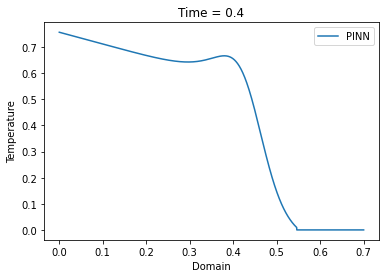

In [25]:
# Temperature Distribution

N_test = 2000

t_pred = 0.4
x_test = torch.linspace(0.7,x_l,N_test)
t_test = torch.ones(N_test)*t_pred
x_test = x_test.unsqueeze(-1)
t_test = t_test.unsqueeze(-1)

y_pred = NN1( torch.cat((x_test, t_test),1) )
s_pred = NN2(t_test)

y_pred = y_pred.detach().numpy()
s_pred = s_pred.detach().numpy()
x_test = x_test.detach().numpy()
t_test = t_test.detach().numpy()

# PINN
for i in range(N_test):
    if(x_test[i]>s_pred[i]):
        y_pred[i] = 0 
plt.plot(x_test, y_pred)
        
# Analytical
s_an = np.sqrt(k1*t_pred)*2*lam
y_an = []
for i in range(N_test):
    if(x_test[i]>s_an):
        y_an.append(0)
    else:
        y_an.append(1 - math.erf( x_test[i]/( 2*np.sqrt(k1*t_test[i]) ) )/ math.erf(lam) )     
# plt.plot(x_test, y_an)

plt.legend(['PINN', 'Analytical'])
plt.title('Time = '+ str(t_pred) )
plt.ylabel('Temperature')
plt.xlabel('Domain')

Text(0, 0.5, 'Interface Position')

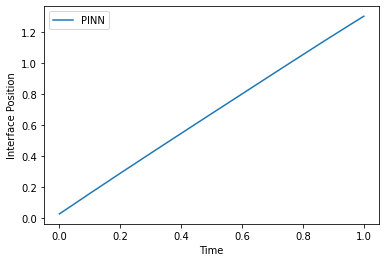

In [21]:
# Interface Position

t_test = torch.linspace(t_i, 1, N_test)
t_test = t_test.unsqueeze(-1)
s_pred = NN2(t_test)
T_interface = NN1( torch.cat((s_pred, t_test),1) )

t_test = t_test.detach().numpy()
s_pred = s_pred.detach().numpy()
T_interface = T_interface.detach().numpy()

plt.plot(t_test,s_pred)
# plt.plot(t_test, np.sqrt(k1*t_test)*2*lam)
plt.legend(['PINN', 'Analytical'])
plt.xlabel('Time')
plt.ylabel('Interface Position')